## **Аналіз та прогнозування результатів маркетингової кампанії банку**

### **Опис задачі**

Метою даного проєкту є побудова моделі машинного навчання для прогнозування ймовірності того, що клієнт банку погодиться на відкриття строкового депозиту. Аналіз проводиться на основі історичних даних про маркетингові телефонні кампанії.

Цільова змінна — `y`, яка набуває значень `yes` або `no`.



Основне завдання:

- проаналізувати дані;

- виконати попередню обробку;

- побудувати та порівняти кілька моделей;

- оптимізувати гіперпараметри;

- проінтерпретувати результати;

- зробити висновки.



### **Опис датасету**

Датасет містить інформацію про клієнтів банку та умови проведення маркетингових кампаній.

Основні групи ознак:
#### **Дані про клієнта банку**:
1. **age** – вік клієнта (числова змінна).  
2. **job** – вид зайнятості (категоріальна змінна: `admin.`, `blue-collar`, `entrepreneur`, `housemaid`, `management`, `retired`, `self-employed`, `services`, `student`, `technician`, `unemployed`, `unknown`).  
3. **marital** – сімейний стан (категоріальна змінна: `divorced`, `married`, `single`, `unknown`; примітка: `divorced` означає розлучений або вдівець/вдова).  
4. **education** – рівень освіти (категоріальна змінна: `basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `illiterate`, `professional.course`, `university.degree`, `unknown`).  
5. **default** – чи є у клієнта прострочений кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
6. **housing** – чи має клієнт іпотечний кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
7. **loan** – чи має клієнт споживчий кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  

#### **Дані про останній контакт у межах поточної маркетингової кампанії**:
8. **contact** – тип зв’язку при останньому контакті (категоріальна змінна: `cellular`, `telephone`).  
9. **month** – місяць останнього контакту (категоріальна змінна: `jan`, `feb`, `mar`, …, `nov`, `dec`).  
10. **day_of_week** – день тижня останнього контакту (категоріальна змінна: `mon`, `tue`, `wed`, `thu`, `fri`).  
11. **duration** – тривалість останнього контакту в секундах (числова змінна).  
  
#### **Інші атрибути**:
12. **campaign** – кількість контактів у межах поточної кампанії для цього клієнта (числова змінна, включає останній контакт).  
13. **pdays** – кількість днів, що минули з моменту останнього контакту клієнта у попередній кампанії (числова змінна; значення 999 означає, що клієнт раніше не контактувався).  
14. **previous** – кількість контактів, здійснених до цієї кампанії для цього клієнта (числова змінна).  
15. **poutcome** – результат попередньої маркетингової кампанії (категоріальна змінна: `failure`, `nonexistent`, `success`).  

#### **Атрибути соціально-економічного контексту**:
16. **emp.var.rate** – темп зміни зайнятості (щоквартальний показник, числова змінна).  
17. **cons.price.idx** – індекс споживчих цін (щомісячний показник, числова змінна).  
18. **cons.conf.idx** – індекс довіри споживачів (щомісячний показник, числова змінна).  
19. **euribor3m** – ставка Euribor на 3 місяці (щоденний показник, числова змінна).  
20. **nr.employed** – кількість працевлаштованих осіб (щоквартальний показник, числова змінна).  

#### **Цільова змінна**:
21. **y** – чи підписав клієнт строковий депозит? (бінарна змінна: `yes`, `no`).




### **Імпорт бібліотек та завантаження даних**

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import shap



In [ ]:
import importlib
import functions

importlib.reload(functions)

from functions import bi_cat_normplot, predict_and_plot, predict_and_plot_with_threshold

In [ ]:
df = pd.read_csv('bank-additional-full.csv',sep=';')

In [ ]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### **Дослідницький аналіз даних (EDA)**

In [ ]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [ ]:
df['y'].value_counts()

,count
y,
0,36548
1,4640


З загального аналізу датасету бачимо, що пропуски у даних відсутні. Також можна помітити дисбаланс класів у цільовій колонці.

#### Кореляційний аналіз числових ознак

In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df.corr()['y']

,y
age,0.030399
duration,0.405274
campaign,-0.066357
pdays,-0.324914
previous,0.230181
emp.var.rate,-0.298334
cons.price.idx,-0.136211
cons.conf.idx,0.054878
euribor3m,-0.307771
nr.employed,-0.354678


In [ ]:
numeric_df.corr()['y'].abs().sort_values(ascending=False)

,y
y,1.000000
duration,0.405274
nr.employed,0.354678
pdays,0.324914
euribor3m,0.307771
emp.var.rate,0.298334
previous,0.230181
cons.price.idx,0.136211
campaign,0.066357
cons.conf.idx,0.054878


In [ ]:
def num_dist(df, column, hue_column):
    plt.scatter(df[column], df[hue_column], alpha=0.1)
    plt.xlabel(column)
    plt.ylabel(hue_column)
    plt.title(f'Розподіл цільової змінної {hue_column} залежно від {column}')
    plt.show()

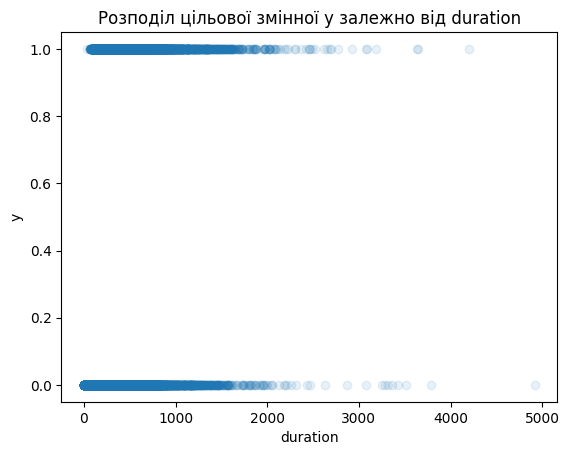

In [ ]:
num_dist(df, 'duration', 'y')

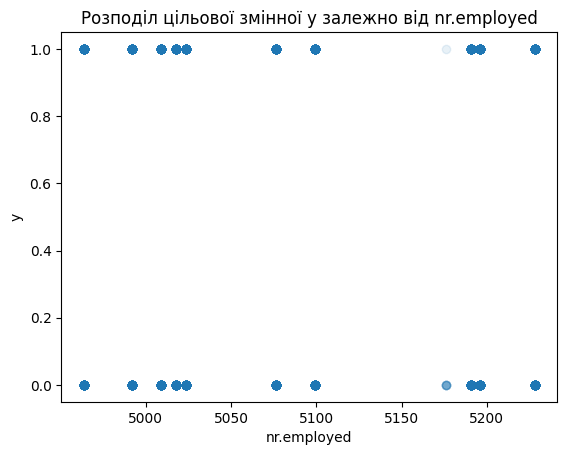

In [ ]:
num_dist(df, 'nr.employed', 'y')

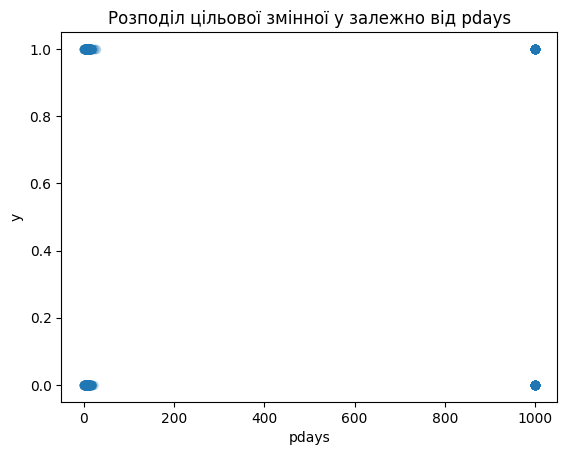

In [ ]:
num_dist(df, 'pdays', 'y')

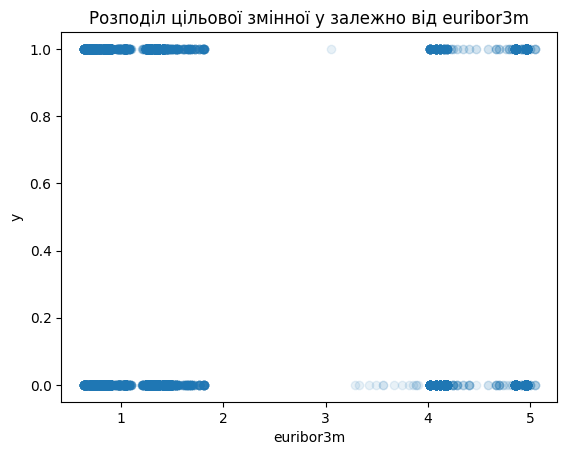

In [ ]:
num_dist(df, 'euribor3m', 'y')

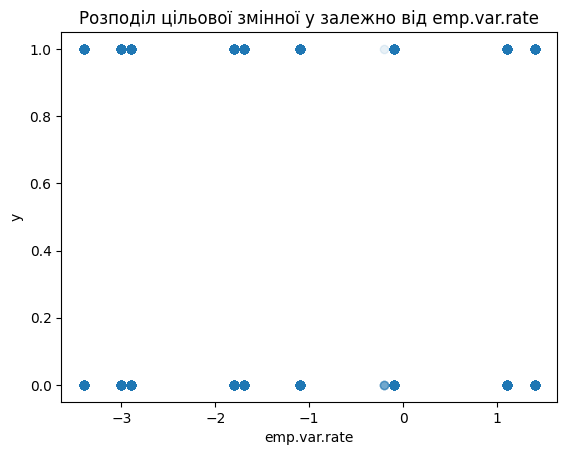

In [ ]:
num_dist(df, 'emp.var.rate', 'y')

Висновки:
- З аналізу числових ознак можемо побачити, що найвплівовішою є `duraton` за модулем коеіцієнта кореляції, також вона єдина з числових ознак, яка при значенні `0` однозначно дає значення `y` рівне нулю.
- Також можна помітити ще три найбільш впливові числові ознаки (коефіціент кореляції яких >=0.3): `nr.employed` - відображає загальний стан економічної ситуації, `pdays` - клієнти, яким давно не телефонували частіше погоджуються, `euribor3m` - високі відсоткові ставки роблять депозити більш привабливими.

#### Кореляційний аналіз категоріальних ознак

 Аналіз `education`

In [ ]:
df.education.value_counts()

,count
education,
university.degree,12168
high.school,9515
basic.9y,6045
professional.course,5243
basic.4y,4176
basic.6y,2292
unknown,1731
illiterate,18


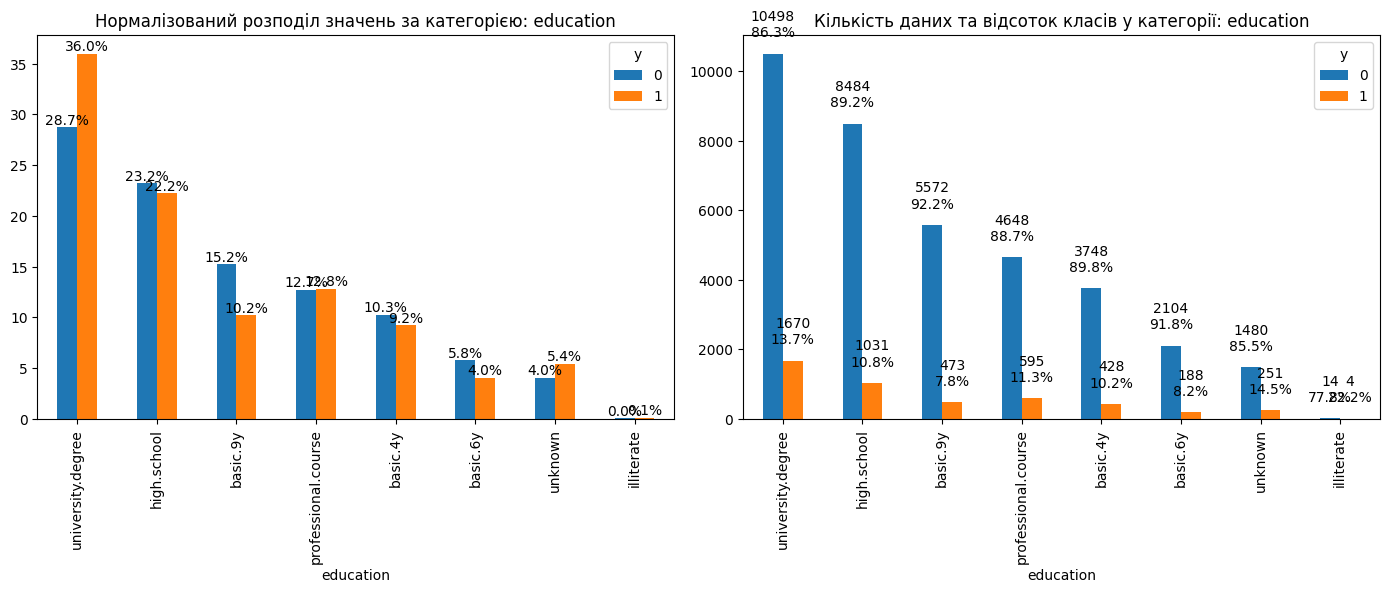

In [ ]:
bi_cat_normplot(df, 'education', 'y')

- З графіків можна помітити, що найбільший відсоток класу `yes` у категорії `illiterate`, проте через те що у цій категорії дуже мало прикладів (18) скоріш за все це статистичний шум, ніж реальна закономірність.
- Можна помітити загальну тенденцію, що чим краще рівень освіти тим більше відсоток класу `yes`.
- В категорії `unknown` 1731 прикладів, найвищий відсоток класу `yes`. Виключати її не слід, тому що прикладів досить багато та вони несуть інформацію. Заміняти значення на моду теж не будемо, тому що ця категорія показуює підвищений відклик. Залишаємо цю категорію як є. Перед побудуванням ансамблевої моделі цю категорію закодуємо як NaN.
- Цю ознаку будемо кодувати за допомогою `OneHotEncoder`

Аналіз `job`

In [ ]:
df.job.value_counts()

,count
job,
admin.,10422
blue-collar,9254
technician,6743
services,3969
management,2924
retired,1720
entrepreneur,1456
self-employed,1421
housemaid,1060


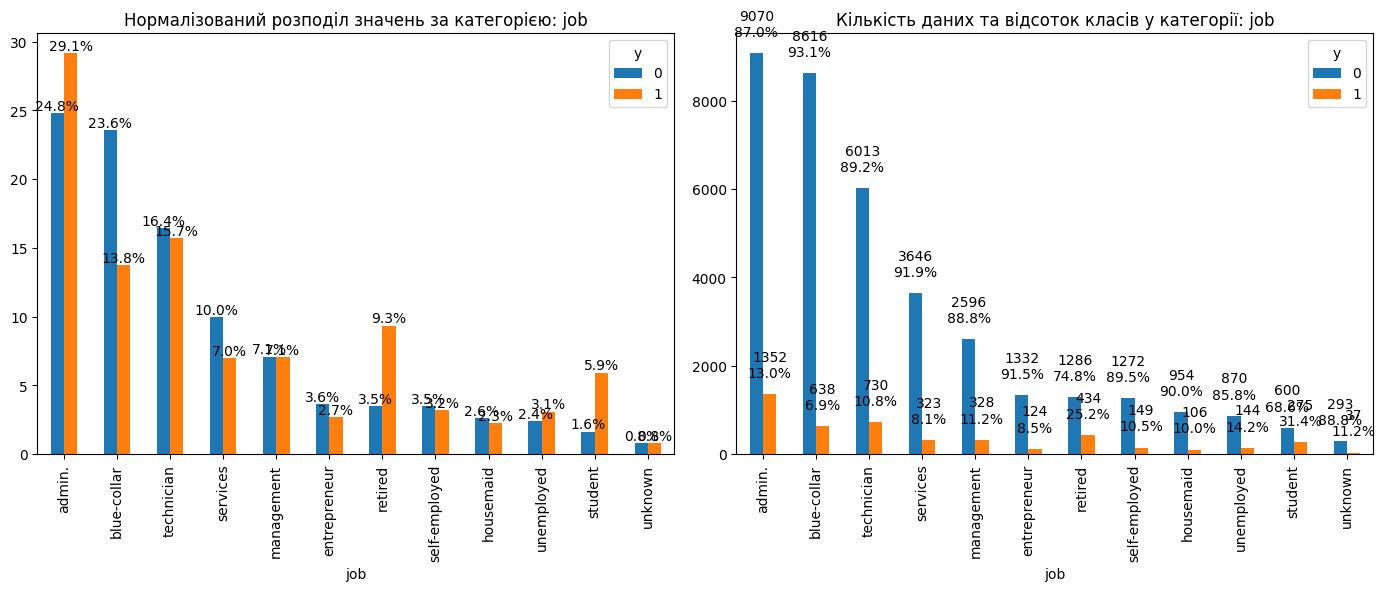

In [ ]:
bi_cat_normplot(df, 'job', 'y')

Аналізуючи графіки можна побачити певну закономірність:
- представники економіно-неактивної категорії (тобто студенти та пенсіонери) мають найбільший відсоток класу `yes` цільової змінної `students` - 31.4%, `retired` - 25.2%
- у `unemployed` цей відсоток складає 14.2%. Це не очевидно, проте можна припустити, що у безробітних людей є більше часу на те, щоб вислухати пропозицію та позитивно на неї відреагувати.
- представники умовного "середнього класу" (`admin.`, `management`, `technician`, `housemaid`, `self-employed`) мають відсоток класу `yes` цільової змінної в діапазоні 10%-11.2%
- підприємці та представники робочих професій та сфери послуг: `entrepreneur` - 8.5%, `services` - 8.1%, `blue-collar` - 6.9%, що теж досить логічно.
- представники категорії `unknown` мають 11.2% класу `yes` цільової змінної, що потрапляє у діапазон для "середнього класу", та не робить викидів. Лишаємо цю категорію як окрему. Перед побудуванням ансамблевої моделі цю категорію закодуємо як NaN.\
Цю ознаку теж будемо кодувати за допомогою `OneHotEncoder`.

Аналіз `marital`

In [ ]:
df.marital.value_counts()

,count
marital,
married,24928
single,11568
divorced,4612
unknown,80


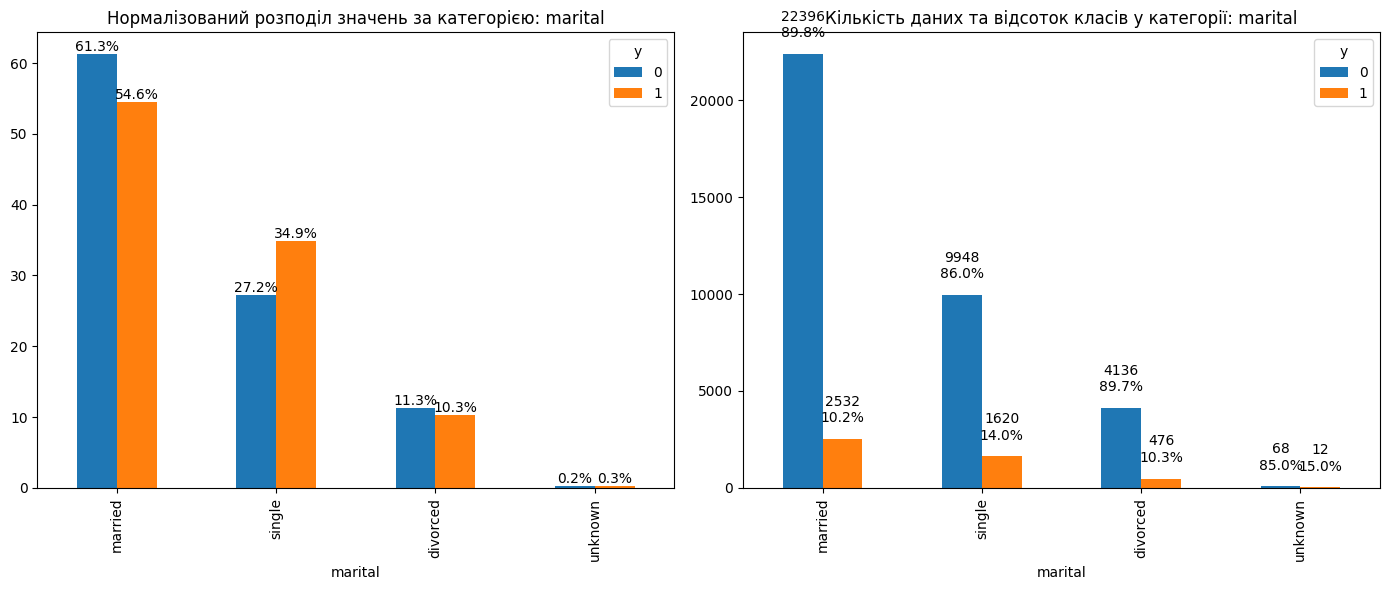

In [ ]:
bi_cat_normplot(df, 'marital', 'y')

- В данній колонці виділяється категорія `single` - 14%
- `married`(10.2%) та `divorced` (10.3%) майже не відрізняються. Можно об'єднати їх у одну категорію `in_relationship`
- в `unknown` найбільший відсоток 15%, проте через маленьку кількість прикладів для того щоб робити висновки.

Аналіз `default`

In [ ]:
df.default.value_counts()

,count
default,
no,32588
unknown,8597
yes,3


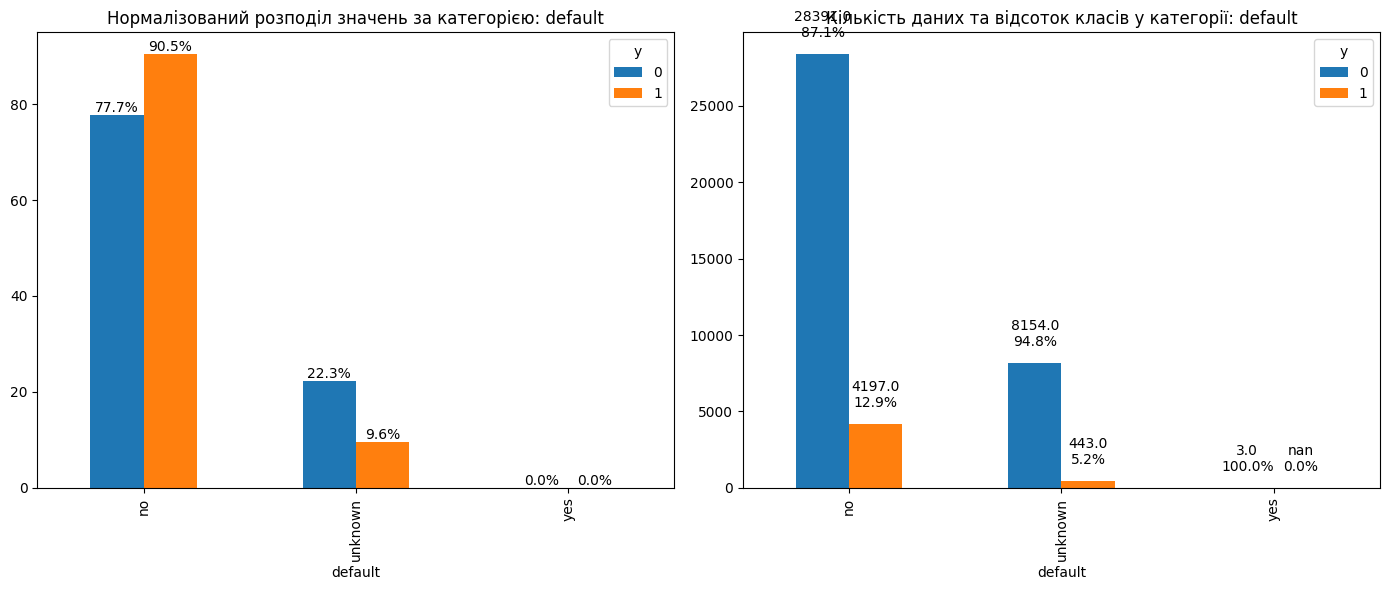

In [ ]:
bi_cat_normplot(df, 'default', 'y')

- категорія `yes` (тобто коли у клієнта є просрочка по кредиту) - всього 3 записи. Модель не зможе витягти з цієї категорії ніякого корисного сигналу.
- категорія `no` (клієнт не має просрочокпо кредиту) 12.9% - це нормальний показник
- категорія `unknown` 8597 записів з 5.2% класу `yes` цільової змінної. Ці клієнти менш прозорі для банку, можливо вони мають слабку кредитну історію.\
Пропонується додати значення категорії `yes` до категорії `unknown`та закодувати за допомогою `OneHotEncoder(drop='first')`

Аналіз `housing`

In [ ]:
df.housing.value_counts()

,count
housing,
yes,21576
no,18622
unknown,990


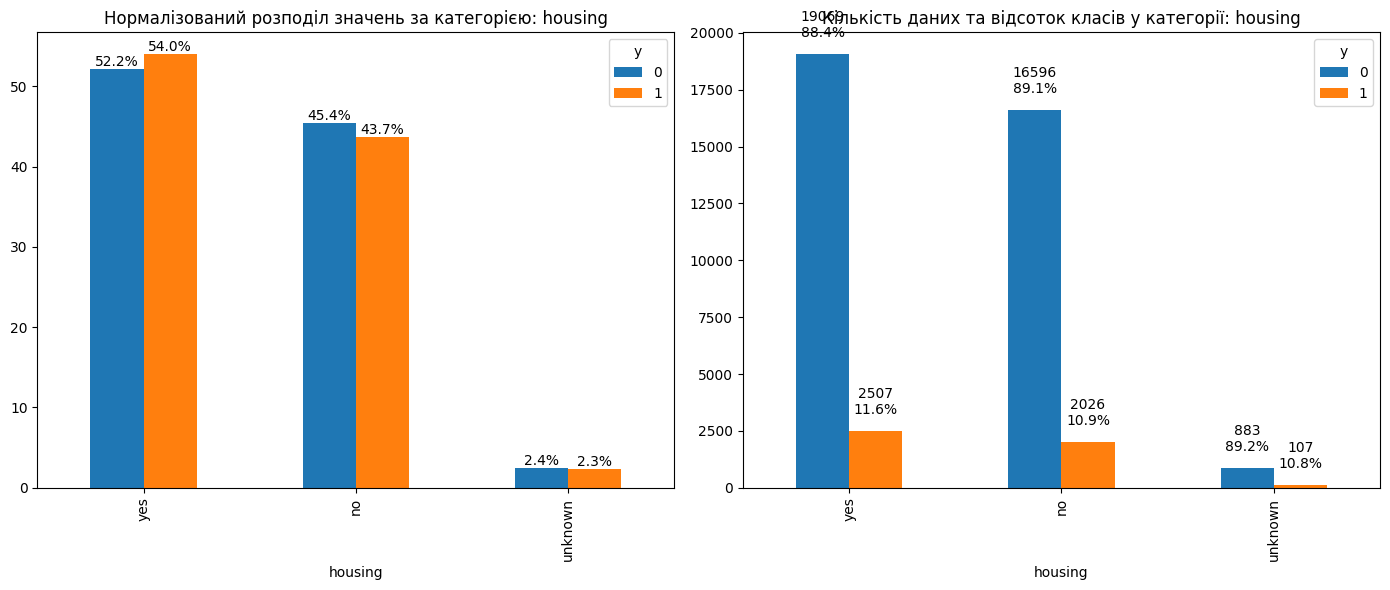

In [ ]:
bi_cat_normplot(df, 'housing', 'y')

- З графіків видно, що наявніть іпотечного кредиту майже не впливає на цільову змінну
- Категорію `unknown` пропоную об'єднати з категорією `no` з двох причин: по-перше - у цих двох категорій дуже схожий відсоток класу `yes` цільової змінної, по-друге - якщо банк не має інформації про наявність у клієнта іпотечного кредита, то скоріш за все це означає відсутність кредиту.
- Кодувати цю ознаку будемо як бінарну категорію.

Аналіз `loan`

In [ ]:
df.loan.value_counts()

,count
loan,
no,33950
yes,6248
unknown,990


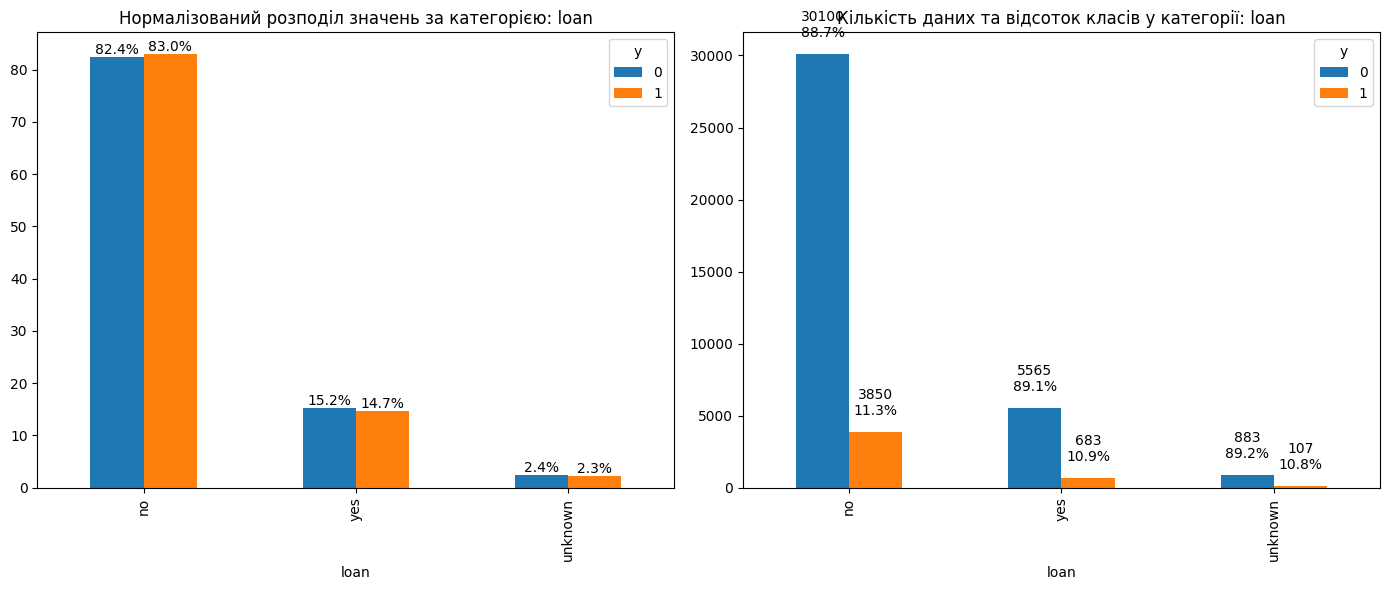

In [ ]:
bi_cat_normplot(df, 'loan', 'y')

- Схоже що ця категорія майже не впливає на цільову змінну
- категорію `unknown` об'єднаємо з `no` та закодуємо цю ознаку як бінарну категорію.

Аналіз `contact`

In [ ]:
df.contact.value_counts()

,count
contact,
cellular,26144
telephone,15044


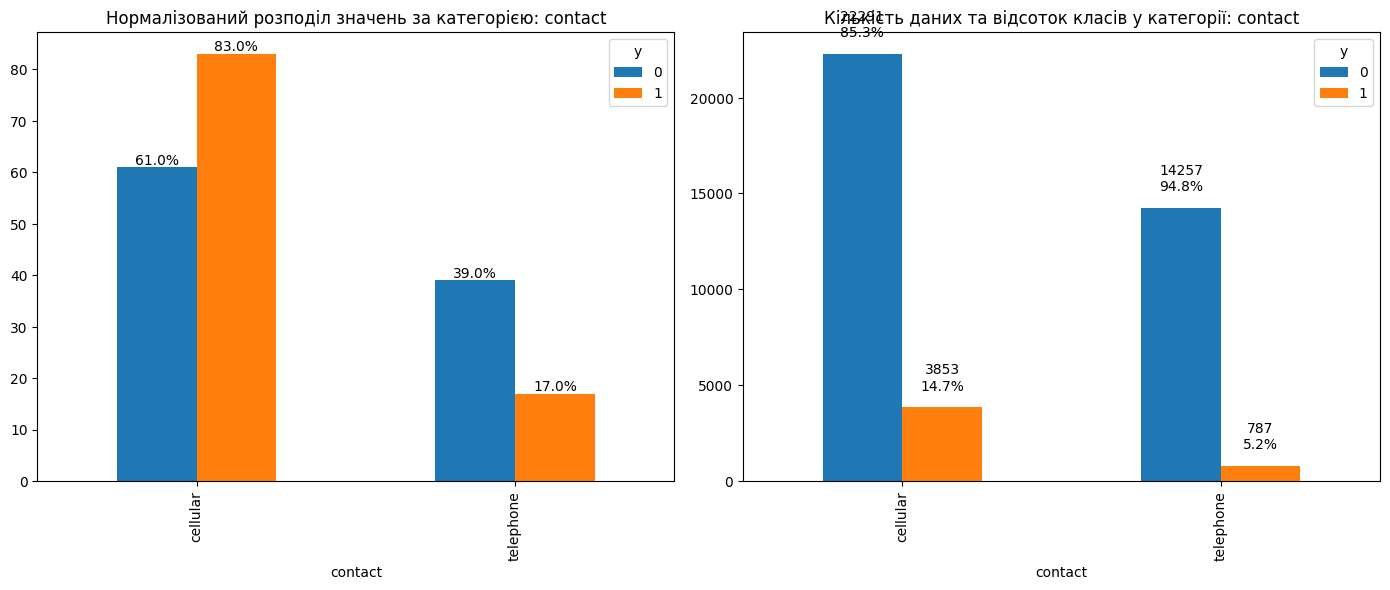

In [ ]:
bi_cat_normplot(df, 'contact', 'y')

Помітна різниця у відсодках клієнтів, що погодилися на депозит. Скоріш за все це пов'язано з тим, що мобільний телефон - більш актуальний та приватний канал зв'язку, що підвищує конверсію.
Ця ознака є однією з впливовіших серед категоріальних ознак.
Кодуватимемо за жопомогою `OneHotEncoder(drop="first")`

Аналіз `month`

In [ ]:
df.month.value_counts()

,count
month,
may,13769
jul,7174
aug,6178
jun,5318
nov,4101
apr,2632
oct,718
sep,570
mar,546


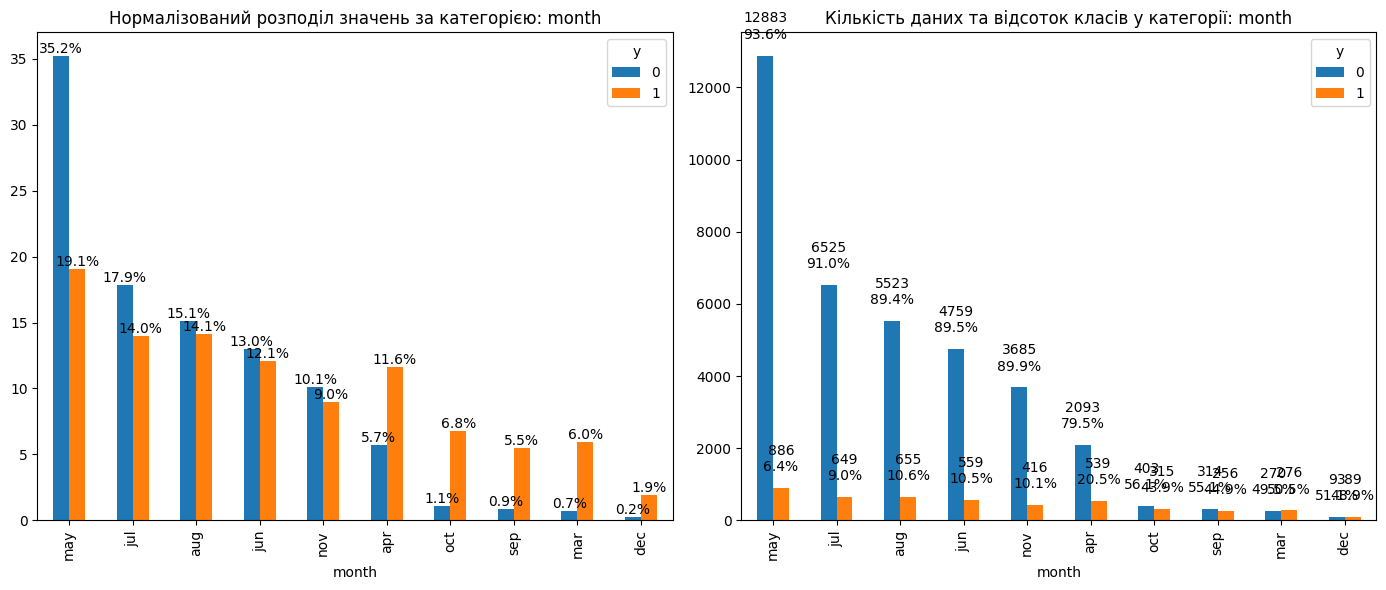

In [ ]:
bi_cat_normplot(df, 'month', 'y')

- З графіків видно, що весна-літо мають найнижчі значення (6-11%), а пізня осінь-зима-рання весна мають величезний відсоток відгуку (20-50%). Це типова ситуація для макретингових банківських компаній. Місяці з аномально визокими показниками `mar` (50.5%), `dec` (49.9%), `sep`-`oct` (44–45%), мають досить мало прикладів. Скоріш за все це і є причина таких високих результатів
- Для кодування пропоную об'єднати місяці у групи за рівнем конверсії, також враховуючи той факт, що в базі даних присутні не всі місяці, для того, щоб модель можна було використовувати навіть з місяцями, яких в датасеті не було, та закодувати з `OneHotEncoder`. Пропоную наступні групи:\
`low`: `may`, `jun`, `jul`, `aug`, `nov`\
`mid`: `apr`\
`high`: `mar, sep, oct, dec`\
`unseen`: `jan, feb`

Аналіз `day_of_week`

In [ ]:
df.day_of_week.value_counts()

,count
day_of_week,
thu,8623
mon,8514
wed,8134
tue,8090
fri,7827


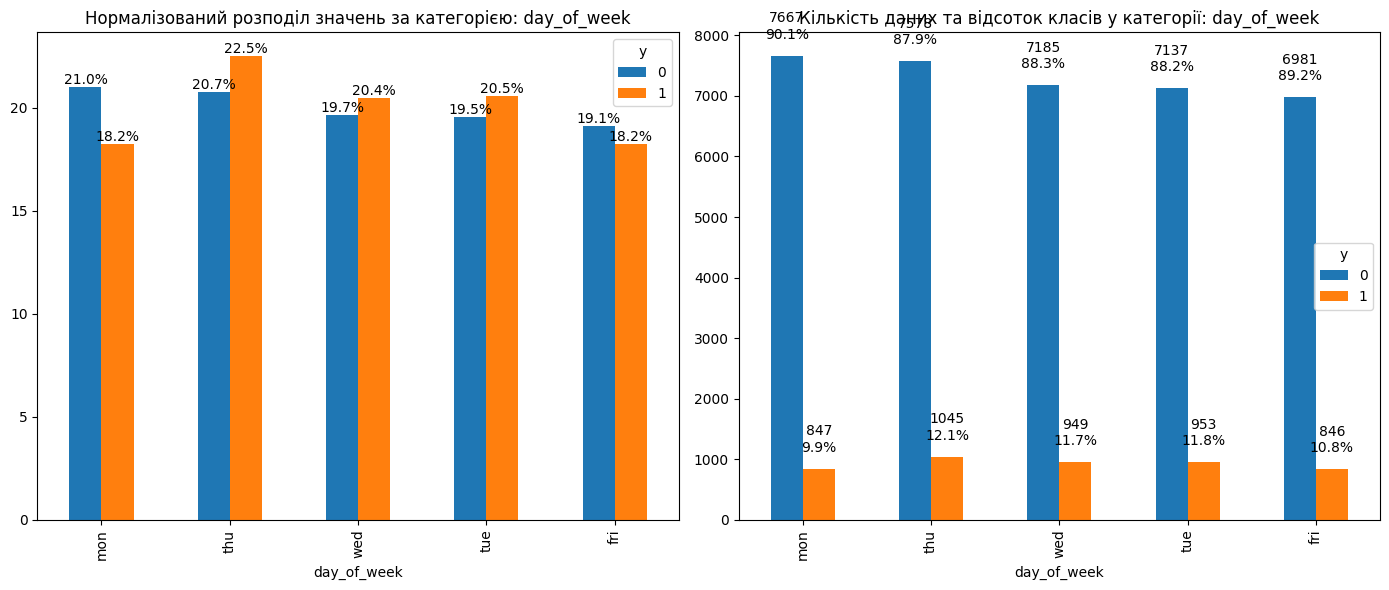

In [ ]:
bi_cat_normplot(df, 'day_of_week', 'y')

- З графіків видно, що ця ознака майже не впливає на цільову змінну. Кодувати будемо з `OneHotEncoder(drop='first')`

Аналіз `poutcome`

In [ ]:
df.poutcome.value_counts()

,count
poutcome,
nonexistent,35563
failure,4252
success,1373


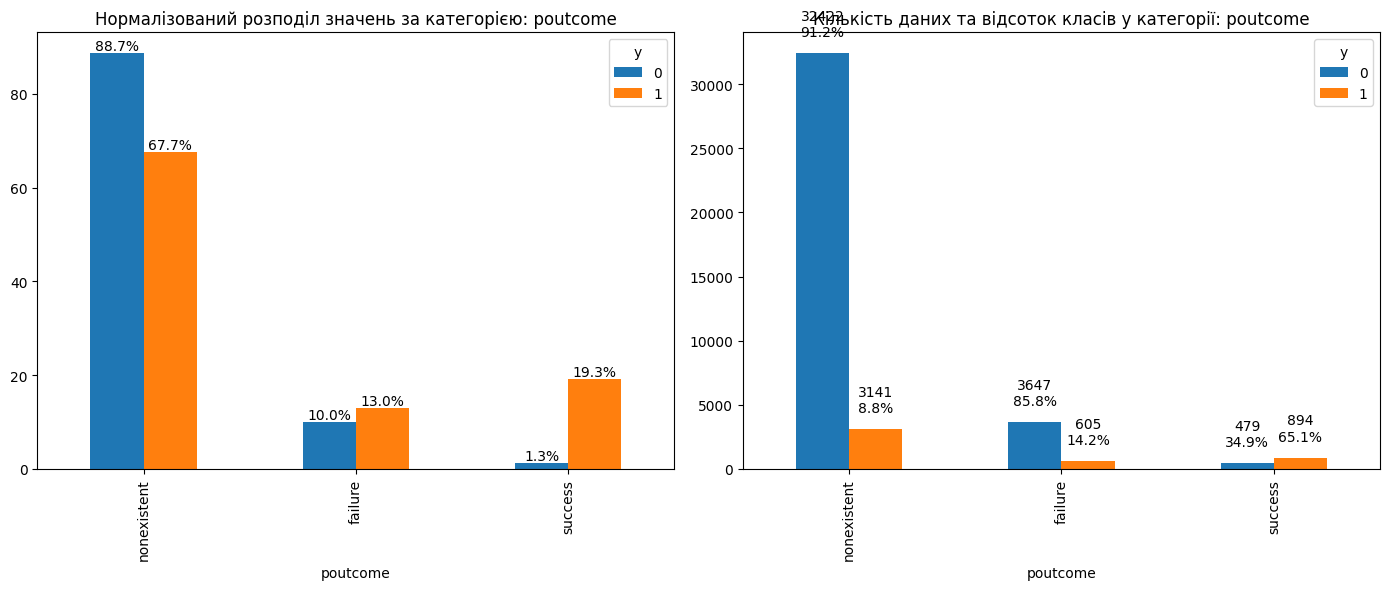

In [ ]:
bi_cat_normplot(df, 'poutcome', 'y')

`poutcome` - одна з найвпливовіших категоріальних ознак. Прослідковується пряма причинна логіка:
- `success` 19.3% - клієнт хоча б один раз погоджувавсяу минулому, у нього вище лояльність та, як наслідок, вище ймовірність того, що клієнт погодиться;
- `failure` 13.0% - клієнт приймав участь, але не погодився. Він не повністю байдужий. Ймовірність вище ніж у `nonexistent`;
- `nonexistent` - клієнти, яких не долучали. "Байдужі" клієнти = нижче конверсія.

Кодувати будемо з `OrdinalEncoder`.

#### Висновок

Якщо узагальнити висновки:
- змішані ознаки
- велика кількість категоріальни ознак
- дисбаланс класів
- хороша корреляція деяких ознак

Враховучи все вищезазначене доцільним буде використання наступних моделей:
- `Logistic Regression` як baseline
- `Random Forest`
- `kNN` - скоріш за все не дуже хороший варіант у випадку з нашим датасетом (через великий розмір даних, велику кількість категоріальних ознак(після кодування ознак буде ще більше), дисбаланс цільової змінної і т.д.), але для порівняння ми натренуємо цю модель.
- `XGBoost`

Для коректного порівняння алгоритмів кожен класифікатор навчатимемо з препроцесингом, оптимальним для класу моделей. Оцінку проводитимо з використанням стратифікованої крос-валідації та метрики ROC-AUC. В нашому випадку це найкращий варіант, тому що в датасеті є сильний дисбаланс класів цільової змінної, задача банку знайти клієнтів, які погодяться на депозит.

### **Препроцесинг**

#### Групування ознак

In [ ]:
job_mapping = {
    'blue-collar': 'Working_class',
    'services': 'Working_class',
    'admin.': 'Middle_class',
    'technician': 'Middle_class',
    'management': 'Middle_class',
    'self-employed': 'Middle_class',
    'entrepreneur': 'Middle_class',
    'housemaid': 'Middle_class',
    'unemployed': 'Unemployed',
    'student': 'Economically_inactive',
    'retired': 'Economically_inactive',
    'unknown': 'Unknown'
}
df['job'] = df['job'].map(job_mapping)


month_mapping = {
    'may': 'low', 'jun': 'low', 'jul': 'low', 'aug': 'low', 'nov': 'low',
    'apr': 'mid',
    'mar': 'high', 'sep': 'high', 'oct': 'high', 'dec': 'high',
    'jan': 'unseen', 'feb': 'unseen'
}
df['month'] = df['month'].map(month_mapping)


df['marital'] = df['marital'].replace({'married': 'in_relationship', 'divorced': 'in_relationship'})


df['default'] = df['default'].replace({'yes': 'unknown'})
df['housing'] = df['housing'].replace({'unknown': 'no'})
df['loan'] = df['loan'].replace({'unknown': 'no'})


#### Підготовка даних та розбиття на тренувальний та тестовий набори

In [ ]:
y = df['y']
X = df.drop('y', axis=1)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

#### Препроцесори

- Логістична регресія

In [ ]:
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

- Дерево прийняття рішень

In [ ]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

- KNN

In [ ]:
cat_cols_knn = ['job', 'marital','month', 'education', 'contact',  'poutcome']

In [ ]:
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_knn)
    ]
)

- XGBoost

In [ ]:
def replace_unknown_with_nan(X):
    X = X.copy()
    cols = ['education', 'job', 'marital']
    for col in cols:
        X[col] = X[col].replace('unknown', np.nan)
    return X

In [ ]:
unknown_to_nan = FunctionTransformer(
    replace_unknown_with_nan,
    validate=False
)

In [ ]:
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=np.nan
        ), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

### **Моделі**

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    missing=np.nan,
    random_state=42,
    n_jobs=-1
)

In [ ]:
pipe_lr = Pipeline([
    ('prep', preprocessor_lr),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

pipe_tree = Pipeline([
    ('prep', preprocessor_tree),
    ('model', DecisionTreeClassifier(
        max_depth=6,
        class_weight='balanced',
        random_state=42
    ))
])

pipe_knn = Pipeline([
    ('prep', preprocessor_knn),
    ('model', KNeighborsClassifier(
        n_neighbors=15,
        weights='distance'
    ))
])

pipe_xgb = Pipeline(
    steps=[
        ('unknown_to_nan', unknown_to_nan),
        ('preprocessing', xgb_preprocessor),
        ('model', xgb_model)
    ]
)


#### Проміжні результати

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_tree,
    'KNN': pipe_knn,
    'XGBoost': pipe_xgb
}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc'
    )
    print(f'{name}: ROC-AUC CV = {scores.mean():.4f} ± {scores.std():.4f}')

Logistic Regression: ROC-AUC CV = 0.9320 ± 0.0042
Decision Tree: ROC-AUC CV = 0.9302 ± 0.0059
KNN: ROC-AUC CV = 0.9152 ± 0.0045
XGBoost: ROC-AUC CV = 0.9475 ± 0.0030


Area under ROC score on Logistic Regression Train dataset: 93.30%


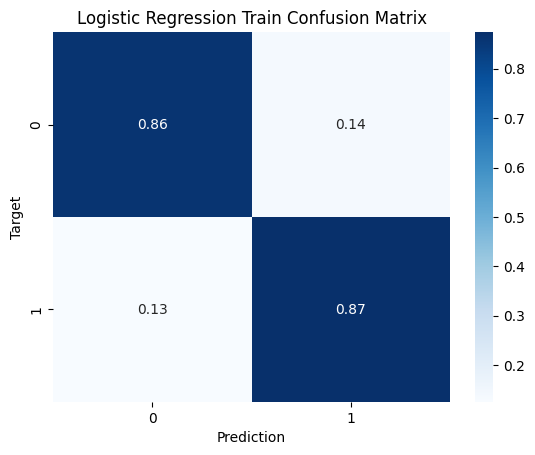

Area under ROC score on Logistic Regression Test dataset: 94.06%


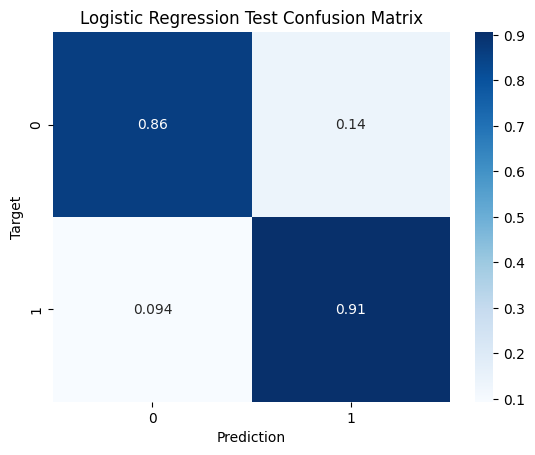

Area under ROC score on Decision Tree Train dataset: 94.57%


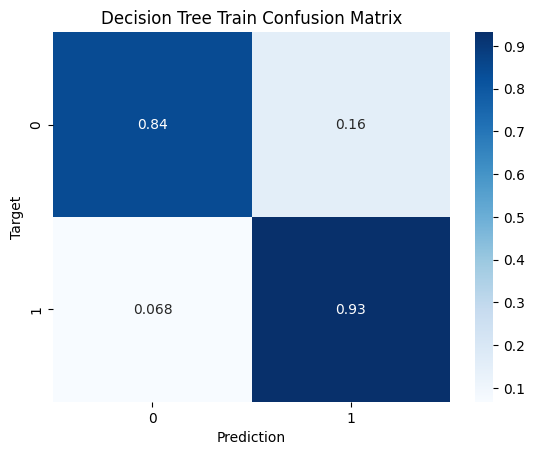

Area under ROC score on Decision Tree Test dataset: 94.18%


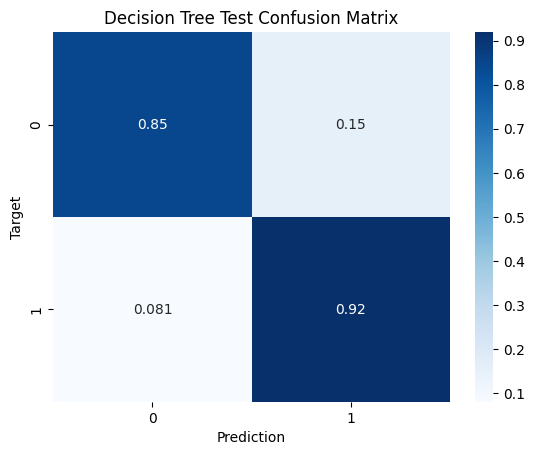

Area under ROC score on KNN Train dataset: 100.00%


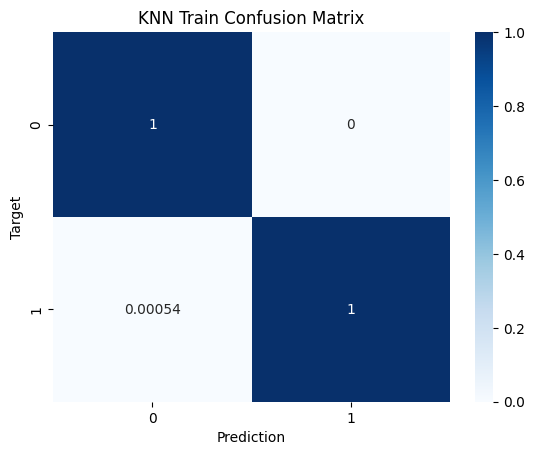

Area under ROC score on KNN Test dataset: 92.72%


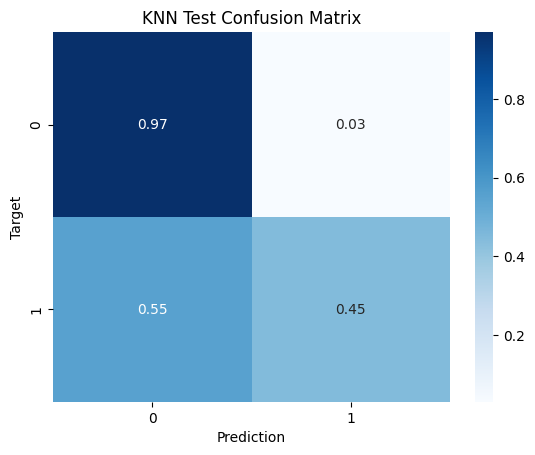

Area under ROC score on XGBoost Train dataset: 97.48%


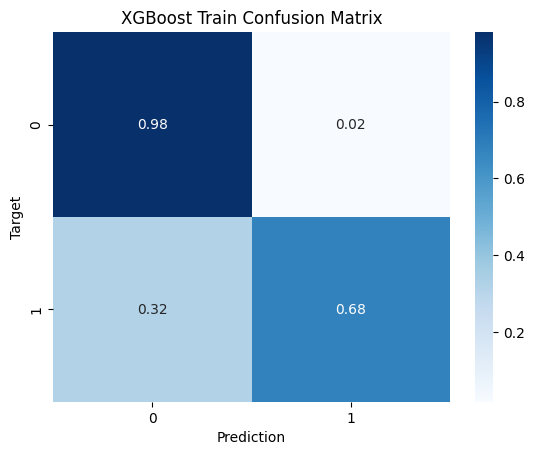

Area under ROC score on XGBoost Test dataset: 95.45%


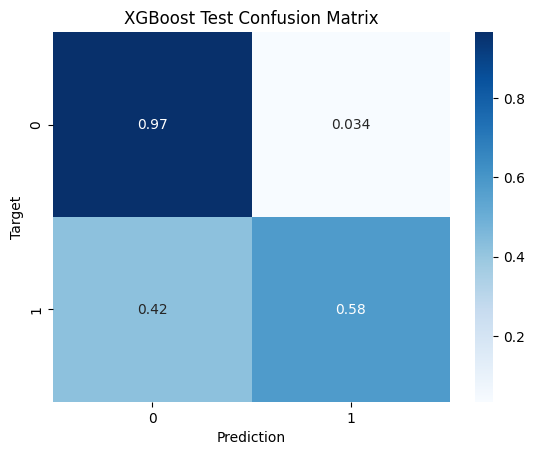

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    predict_and_plot(model, X_train, y_train, name=name+" Train")
    predict_and_plot(model, X_test, y_test, name=name+" Test")

Висновок:
- `XGBoost` - найкраща модель з побудованих. Значення `auroc` на `CV` (0.9475 ± 0.0030) та порівняння тренувальних та тестувальних наборів (Train: 97.48% Test:  95.45%) говорить про те, що це досить сильна модель. Незначна різниця між результатами на тренувальних та тестувальних даних говорить про відсутність недонавчання/перенавчання.
- `Decision Tree` - Теж досить хороші результати, проте менші за `XGBoost`. Дуже маленька різниця між результатами на тестувальних та тренувальних даних (0.39%).
- `Logistic Regression` - дуже непогана модель, результати на тестовому наборі навіть трохи вище за результати на тренувальному. Перенавчання відсутнє.
- `KNN`- Train: 100.00%, Test:  92.72%. Класичне перенавчання, модель запам'ятала тренувальні дані. Також такі результати можуть бути через велику розмірність через використання `OneHotEncoder`. І схоже, що навіть feature selection, що ми провели не допоміг нам вирішити цю пробему. Також не слід забувати про імбалансну ознаку `duration`.

Взагалі ситуація з ознакою `duration` стосується всіх результатів. Через неї всі результати було завищено, тому що є пряма залежність `y` від цієї ознаки. Тож далі побудуємо моделі виключивши цю ознаку з `X`.

#### Запуск без `duration`

- Видалення `duration`

In [ ]:
X_no_duration = X.drop(columns=['duration'])
X_train_no_duration = X_train.drop(columns=['duration'])
X_test_no_duration = X_test.drop(columns=['duration'])

num_cols_no_duration = X_no_duration.select_dtypes(include=['int64', 'float64']).columns.tolist()


- Препроцесори

In [ ]:
preprocessor_lr_no_duration = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_no_duration),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

preprocessor_tree_no_duration = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

cat_cols_knn_no_duration = ['job', 'marital','month', 'education', 'contact',  'poutcome']
preprocessor_knn_no_duration = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_no_duration),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_knn_no_duration)
    ]
)

unknown_to_nan_no_duration = FunctionTransformer(
    replace_unknown_with_nan,
    validate=False
)
xgb_preprocessor_no_duration = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=np.nan
        ), cat_cols),
        ('num', 'passthrough', num_cols_no_duration)
    ]
)

In [ ]:
pipe_lr_no_duration = Pipeline([
    ('prep', preprocessor_lr_no_duration),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

pipe_tree_no_duration = Pipeline([
    ('prep', preprocessor_tree_no_duration),
    ('model', DecisionTreeClassifier(
        max_depth=6,
        class_weight='balanced',
        random_state=42
    ))
])

pipe_knn_no_duration = Pipeline([
    ('prep', preprocessor_knn_no_duration),
    ('model', KNeighborsClassifier(
        n_neighbors=15,
        weights='distance'
    ))
])

xgb_model_no_duration = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    missing=np.nan,
    random_state=42,
    n_jobs=-1
)
pipe_xgb_no_duration_no_duration = Pipeline(
    steps=[
        ('unknown_to_nan', unknown_to_nan_no_duration),
        ('preprocessing', xgb_preprocessor_no_duration),
        ('model', xgb_model_no_duration)
    ]
)

models_no_duration = {
    'Logistic Regression': pipe_lr_no_duration,
    'Decision Tree': pipe_tree_no_duration,
    'KNN': pipe_knn_no_duration,
    'XGBoost': pipe_xgb_no_duration_no_duration
}

In [ ]:
for name, model in models_no_duration.items():
    scores = cross_val_score(
        model,
        X_train_no_duration,
        y_train,
        cv=cv,
        scoring='roc_auc'
    )
    print(f'{name}: ROC-AUC CV = {scores.mean():.4f} ± {scores.std():.4f}')

Logistic Regression: ROC-AUC CV = 0.7868 ± 0.0054
Decision Tree: ROC-AUC CV = 0.7839 ± 0.0046
KNN: ROC-AUC CV = 0.7338 ± 0.0079
XGBoost: ROC-AUC CV = 0.7894 ± 0.0027


Area under ROC score on Logistic Regression Train dataset: 79.03%


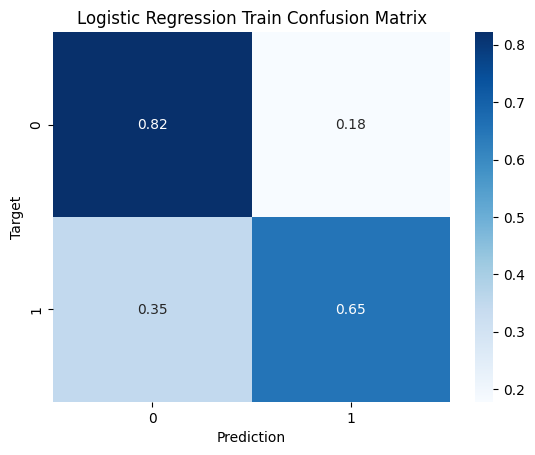

Area under ROC score on Logistic Regression Test dataset: 79.83%


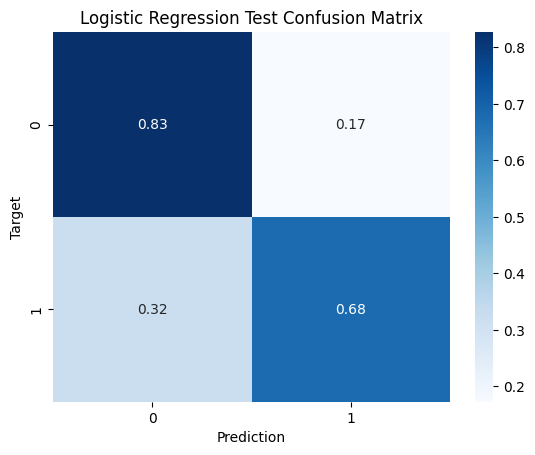

Area under ROC score on Decision Tree Train dataset: 80.13%


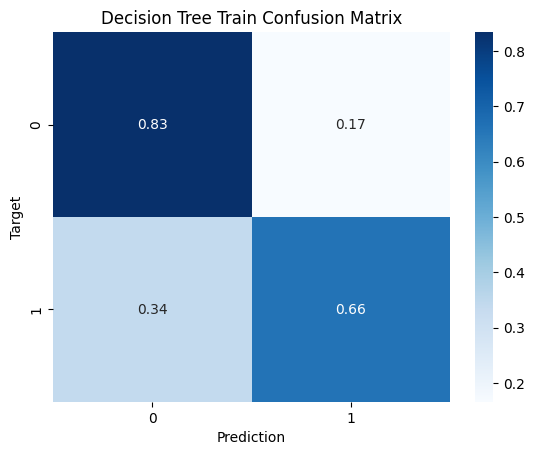

Area under ROC score on Decision Tree Test dataset: 79.27%


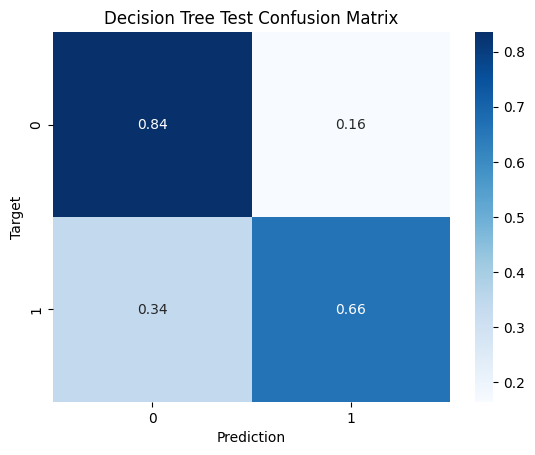

Area under ROC score on KNN Train dataset: 99.79%


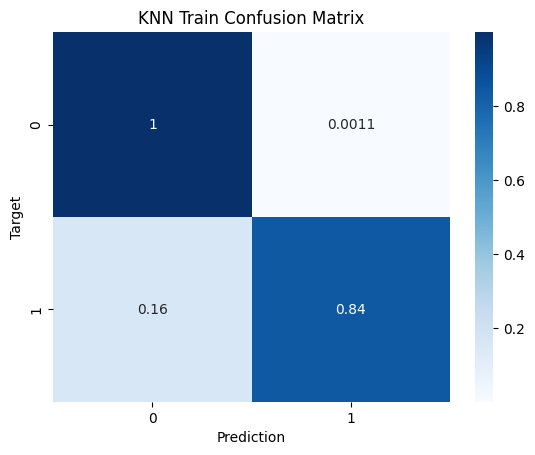

Area under ROC score on KNN Test dataset: 74.19%


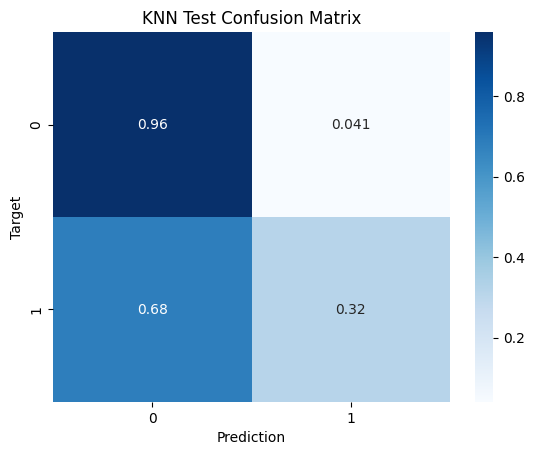

Area under ROC score on XGBoost Train dataset: 87.38%


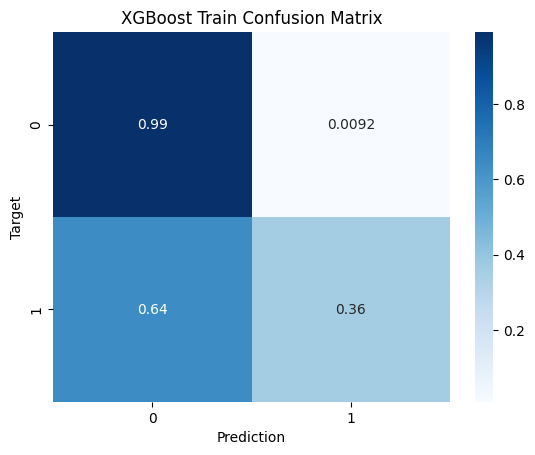

Area under ROC score on XGBoost Test dataset: 81.23%


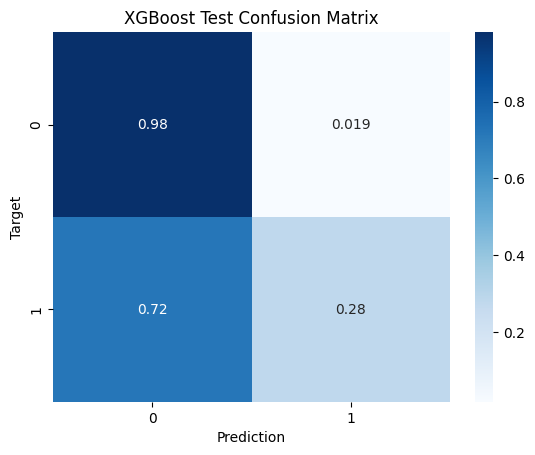

In [ ]:
for name, model in models_no_duration.items():
    model.fit(X_train_no_duration, y_train)
    predict_and_plot(model, X_train_no_duration, y_train, name=name+" Train")
    predict_and_plot(model, X_test_no_duration, y_test, name=name+" Test")

Очікувано показники по всім методам стали нижче.\
Короткий висновок:
- Логістична регресія:
  - Test > Train. Все ще є невеликий underfitting, але видно стабільність моделі
  - Мінімальний ризик перенавчання
- Decision Tree:
  - `auroc` менше ніж у логрегресії
  - більш чуттєва до шуму
- KNN:
  - Дуже сильне перенавчання, яке суттєво не зменшелося навіть при видаленні `duration`. Причини: висока розмірність, несбалансованість класів, запам'ятовування навчального набору.
- XGBoost:
  - найвищий test `auroc`
  - котрольоване перенавчання
  - це наш головний production-кандидат
  - пропонуємо зробити тюнинг гіперпараметрів, щоб ще трохи покращити отримані результати




##### Тюнинг гіперпараметрів з допомогою Randomized Search CV

In [ ]:
xgb_model_RS = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    missing=np.nan,
    random_state=42,
    n_jobs=-1
)

pipe_xgb_RS = Pipeline(
    steps=[
        ('unknown_to_nan', unknown_to_nan_no_duration),
        ('preprocessing', xgb_preprocessor_no_duration),
        ('model', xgb_model_RS)
    ]
)

In [ ]:
param_dist_xgb = {
    'model__n_estimators': randint(300, 900),
    'model__max_depth': randint(3, 7),
    'model__learning_rate': uniform(0.02, 0.08),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': randint(1, 8),
    'model__gamma': uniform(0.0, 0.3)
}

random_search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb_RS,
    param_distributions=param_dist_xgb,
    n_iter=40,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_xgb.fit(X_train_no_duration, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('unknown_to_nan',
                                              FunctionTransformer(func=<function replace_unknown_with_nan at 0x7c400e51ae80>)),
                                             ('preprocessing',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=nan),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'day_...
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c400e8cb830>,
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c400ec0af30>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c400ebe4f80>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c400eb43e90>},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
print(f"Best CV ROC-AUC: {random_search_xgb.best_score_:.4f}")
print("Best parameters:")
for k, v in random_search_xgb.best_params_.items():
    print(f"{k}: {v}")

Best CV ROC-AUC: 0.7991
Best parameters:
model__colsample_bytree: 0.9861021229056552
model__gamma: 0.1821102743060054
model__learning_rate: 0.04207993456180347
model__max_depth: 3
model__min_child_weight: 7
model__n_estimators: 364
model__subsample: 0.6062545626964776


Area under ROC score on XGBoost Tuned (no duration) Train dataset: 81.96%


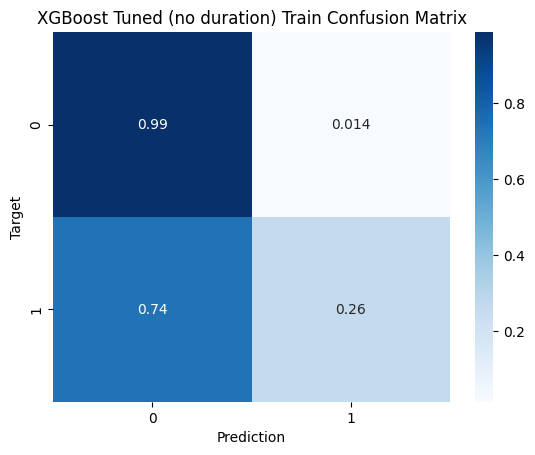

Area under ROC score on XGBoost Tuned (no duration) Test dataset: 81.62%


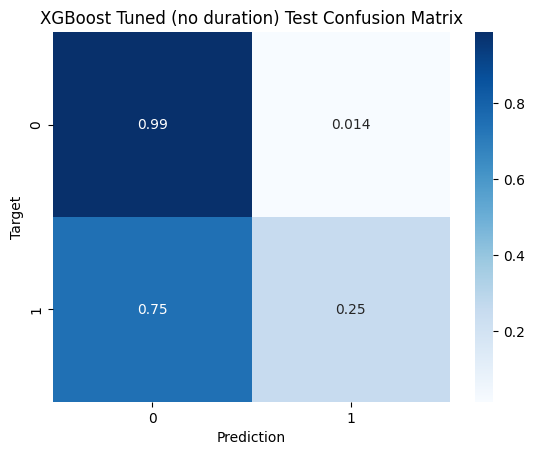

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
best_xgb_rs = random_search_xgb.best_estimator_

predict_and_plot(
    best_xgb_rs,
    X_train_no_duration,
    y_train,
    name='XGBoost Tuned (no duration) Train'
)

predict_and_plot(
    best_xgb_rs,
    X_test_no_duration,
    y_test,
    name='XGBoost Tuned (no duration) Test'
)

Аналізуючи результати можна помітити, що:
- Train ≈ Test. Перенавчання нема.
- Результат трохи краще ніж до тюнинга гіперпараметрів.
- Дивлячись на `Confusion Matrix` можна помітити, що модель дуже добре розпізнає клієнтів які не підпишуть депозит (помилково спрацювало лише 1.4%), але знаходить лише 25% реальних підписников (75% потенційних клієнтів губиться). Але це нормально для сильного дисбалансу класів, стандартного порогу 0.5 та оптимізації по `auroc`.

Висновок:
- тюнинг спрацював
- модель стійка
- `auroc` ≈ 82% - дуже хороший результат без `duration`
- завжди можна скоригувати порог під бізнес-задачу

##### Тюнинг гіперпараметрів з допомогою Hyperopt: Bayesian Optimization

In [ ]:
!pip install hyperopt


In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 300, 800, 50),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.02), np.log(0.15)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 5)
}

In [ ]:
def objective(params):
    xgb_model = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=int(params['min_child_weight']),
        gamma=params['gamma'],
        objective='binary:logistic',
        eval_metric='auc',
        missing=np.nan,
        random_state=42,
        n_jobs=-1
    )

    pipe = Pipeline(
        steps=[
            ('unknown_to_nan', unknown_to_nan_no_duration),
            ('preprocessing', xgb_preprocessor_no_duration),
            ('model', xgb_model)
        ]
    )

    score = cross_val_score(
        pipe,
        X_train_no_duration,
        y_train,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

    return {
        'loss': -score,
        'status': STATUS_OK
    }


In [ ]:
trials = Trials()

best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,   # Bayesian Optimization
    max_evals=40,       # можно 30–50
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 40/40 [04:37<00:00,  6.95s/trial, best loss: -0.8002371875096926]


In [ ]:
best_params = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'learning_rate': float(best_params['learning_rate']),
    'subsample': float(best_params['subsample']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'gamma': float(best_params['gamma'])
}

In [ ]:
best_xgb_hp = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='auc',
    missing=np.nan,
    random_state=42,
    n_jobs=-1
)

pipe_xgb_best_hp = Pipeline(
    steps=[
        ('unknown_to_nan', unknown_to_nan_no_duration),
        ('preprocessing', xgb_preprocessor_no_duration),
        ('model', best_xgb_hp)
    ]
)

Area under ROC score on XGBoost Hyperopt (no duration) Train dataset: 82.29%


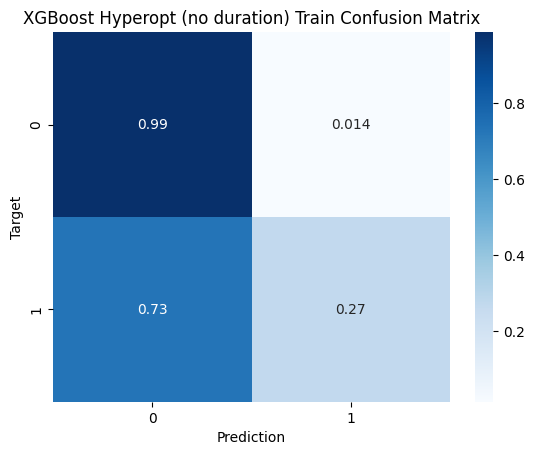

Area under ROC score on XGBoost Hyperopt (no duration) Test dataset: 81.53%


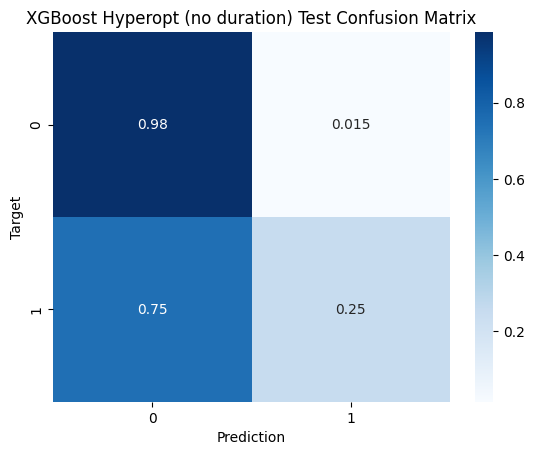

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
pipe_xgb_best_hp.fit(X_train_no_duration, y_train)

predict_and_plot(
    pipe_xgb_best_hp,
    X_train_no_duration,
    y_train,
    name='XGBoost Hyperopt (no duration) Train'
)

predict_and_plot(
    pipe_xgb_best_hp,
    X_test_no_duration,
    y_test,
    name='XGBoost Hyperopt (no duration) Test'
)

Висновок:
- Модель узагальнює хорошо, дуже мала різниця між тренувальним та тестувальним наборами даних
- схожа проблема що й в минулому прикладі з передбаченням класу `yes`. Схоже, що ця проблема має системний характер і пов'язана з надто консервативною межею прийняття рішення. Цю проблему можна частково вирішити змінивши стандартний порог 0.5 на менший.

Схоже що ми наблизилися вже до інформаційної межі:
- XGB (до тюнинга)	~81.2%
- XGB RandomSearch	~81.6%
- XGB Hyperopt	81.5%

##### Налаштування порогового значення

In [ ]:
pipe_xgb_rs_best = random_search_xgb.best_estimator_


XGBoost RS (no duration) — threshold 0.5
Threshold: 0.5
ROC-AUC: 81.62%
Precision: 69.62%
Recall: 25.43%
F1-score: 37.25%


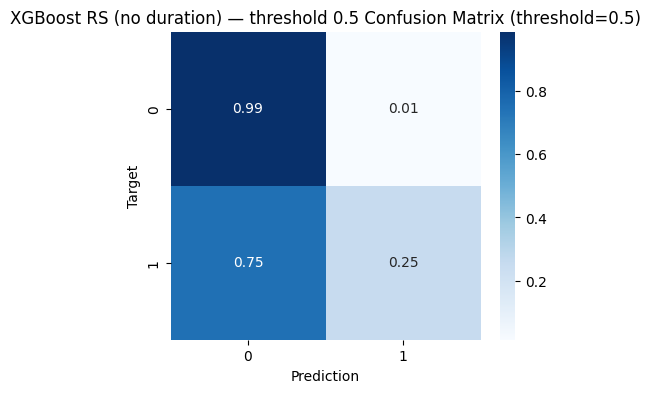

(array([0, 0, 1, ..., 0, 0, 0]),
 array([0.06393951, 0.35756883, 0.55001485, ..., 0.31307745, 0.03175699,
        0.03881126], dtype=float32))

In [ ]:
predict_and_plot_with_threshold(
    model_pipeline=pipe_xgb_rs_best,
    inputs=X_test_no_duration,
    targets=y_test,
    threshold=0.5,
    name='XGBoost RS (no duration) — threshold 0.5'
)


XGBoost RS (no duration) — threshold 0.3
Threshold: 0.3
ROC-AUC: 81.62%
Precision: 52.81%
Recall: 51.72%
F1-score: 52.26%


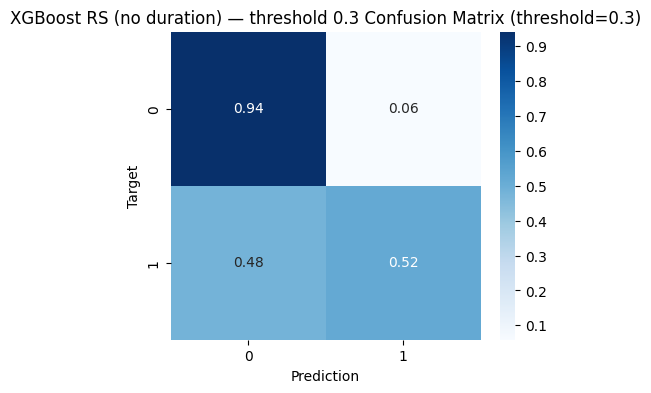

(array([0, 1, 1, ..., 1, 0, 0]),
 array([0.06393951, 0.35756883, 0.55001485, ..., 0.31307745, 0.03175699,
        0.03881126], dtype=float32))

In [ ]:
predict_and_plot_with_threshold(
    model_pipeline=pipe_xgb_rs_best,
    inputs=X_test_no_duration,
    targets=y_test,
    threshold=0.3,
    name='XGBoost RS (no duration) — threshold 0.3'
)


XGBoost RS (no duration) — threshold 0.2
Threshold: 0.2
ROC-AUC: 81.62%
Precision: 47.17%
Recall: 61.10%
F1-score: 53.24%


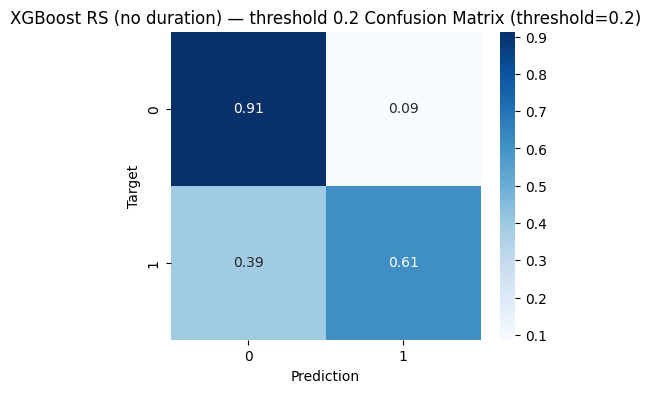

(array([0, 1, 1, ..., 1, 0, 0]),
 array([0.06393951, 0.35756883, 0.55001485, ..., 0.31307745, 0.03175699,
        0.03881126], dtype=float32))

In [ ]:
predict_and_plot_with_threshold(
    model_pipeline=pipe_xgb_rs_best,
    inputs=X_test_no_duration,
    targets=y_test,
    threshold=0.2,
    name='XGBoost RS (no duration) — threshold 0.2'
)

Висновок:
- При фіксованому `auroc` (~81.6%) змінення порогу класифікації не впливає на ранжування об'єктів, але суттєво змінює баланс між `precision` та `recall`. При межи 0.5 модель орієнтована на точність, але тіряє більшість позитивних випадків (`yes`). Знаження порога до 0.3-0.2 дозволяє значно підвищити повноту при помірному зниженні точності, покращуючи `F1-score`. Таким чином, вибір межі є ключовим інструментом адаптації моделі під бізнес-мету без перенавчання моделі.

Тобто, як і передбачалося, зміна порогу дозволила зменшити кількість помилок, що було описано вище, і суттєво підвищити повноту моделі без погіршення її здатності до ранжування (`ROC-AUC`).

### **Аналіз впливу ознак**

In [ ]:
xgb_model = best_xgb_rs.named_steps['model']
importances = xgb_model.feature_importances_
preprocessor = best_xgb_rs.named_steps['preprocessing']
feature_names = preprocessor.get_feature_names_out()
fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fi.head(15)

,feature,importance
18,num__nr.employed,0.562787
14,num__emp.var.rate,0.081484
12,num__pdays,0.062245
7,cat__month,0.050751
9,cat__poutcome,0.037700
16,num__cons.conf.idx,0.033632
6,cat__contact,0.024301
17,num__euribor3m,0.019843
0,cat__job,0.017672
3,cat__default,0.016129


Інтерптретація та висновки:
- `nr.employed` (0.56) - абсолютно домінуюча ознака. це макроекономічний індекатор, що відображає загальний стан ринку труда. Досі логічно та узгоджується з економіним сенсом.
- `emp.var.rate` (0.08) та `euribor3m` (0.019) - показники економічного циклу та відсоткових ставок. Рівень ставок та динаміка економіки напряму впливають на привабливість депозитів. Досить очікувано.
- `pdays` (0.062) - давність попереднього контакту. Одна з найсильніших неекономічних ознак. Якщо з клієнтом давно не контактували, ймовірність позитивного відгуку вища.
- `month` (0.051) и `contact` (0.024) - коли і як контактували з клієнтом. Сезонність та канал зв'язку сильно впливають на конверсію. Це ми помічали ще під час EDA.
- `poutcome` (0.038) и `previous` (0.0107) - історія попередніх компаній. Минулий успіх / неуспіх - сильний індикатор майбутньої поведінки. Це досить логічно.
- `job`, `age`, `marital`, `default`, `day_of_week` - низький внесок у порівнянні з економікою та історією взаємодій. Тип клієнта важливий, але значно слабший, ніж: економічний контекст,
історія контактів, умови пропозиції. Це типово для фінансових продуктів.

Проте пам'ятаємо що feature importance в XGBoost відображає частоту та якість використання ознаки в сплітах, а не причинно-наслідковий зв'язок.


#### Аналіз впливу ознак на передбачення з допомогою бібліотеки SHAP

In [ ]:
xgb_model = best_xgb_rs.named_steps['model']
preprocessor = best_xgb_rs.named_steps['preprocessing']


In [ ]:
X_transformed = preprocessor.transform(X_train_no_duration)
feature_names = preprocessor.get_feature_names_out()

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_transformed)

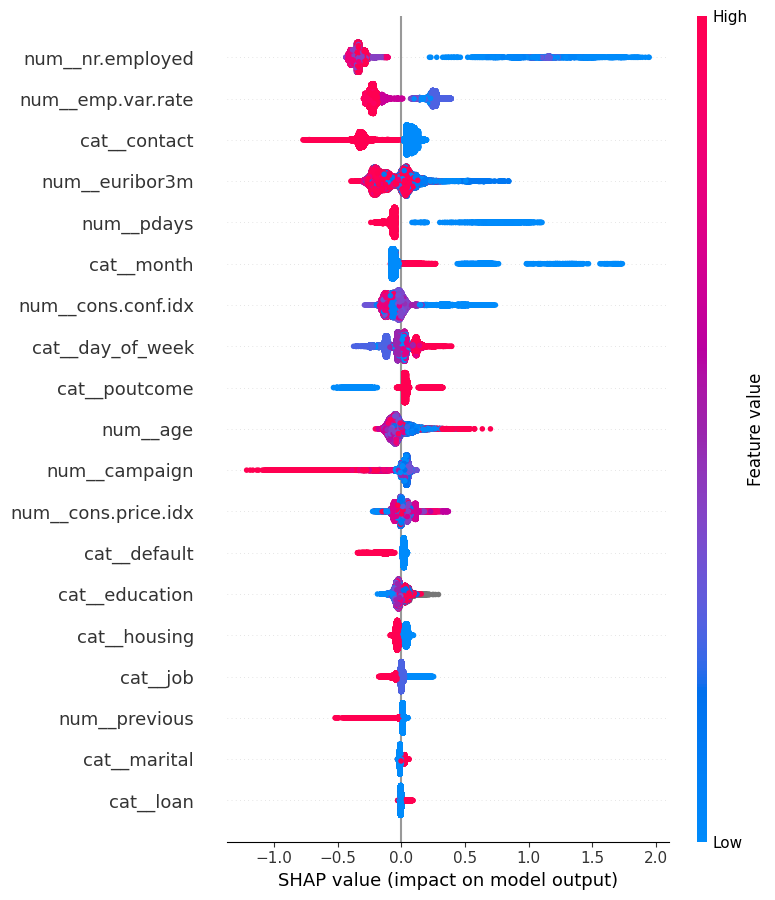

In [ ]:
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=feature_names,
    show=True
)

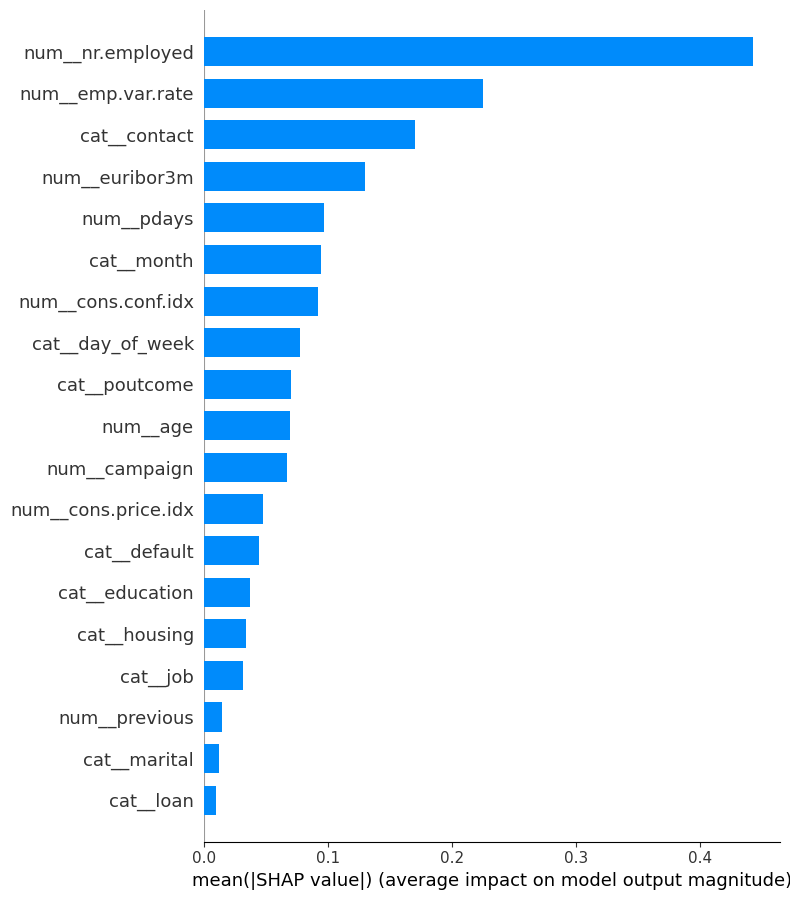

In [ ]:
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=feature_names,
    plot_type='bar',
    show=True
)

In [ ]:
X_train_no_duration

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
25611,49,Working_class,in_relationship,basic.9y,unknown,no,no,cellular,low,wed,4,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
26010,37,Middle_class,in_relationship,university.degree,no,no,no,telephone,low,wed,2,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8
40194,78,Economically_inactive,in_relationship,basic.4y,no,no,no,cellular,low,mon,1,999,0,nonexistent,-1.7,94.215,-40.3,0.870,4991.6
297,36,Middle_class,in_relationship,university.degree,no,yes,no,telephone,low,mon,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
36344,59,Economically_inactive,in_relationship,university.degree,no,no,no,cellular,low,tue,2,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40205,28,Working_class,single,high.school,no,yes,no,cellular,low,tue,1,999,0,nonexistent,-1.7,94.215,-40.3,0.876,4991.6
27316,52,Middle_class,in_relationship,professional.course,no,yes,no,cellular,low,fri,1,999,1,failure,-0.1,93.200,-42.0,4.021,5195.8
14392,54,Middle_class,in_relationship,basic.9y,no,no,yes,cellular,low,mon,4,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
7494,29,Middle_class,in_relationship,university.degree,no,no,no,telephone,low,fri,1,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0


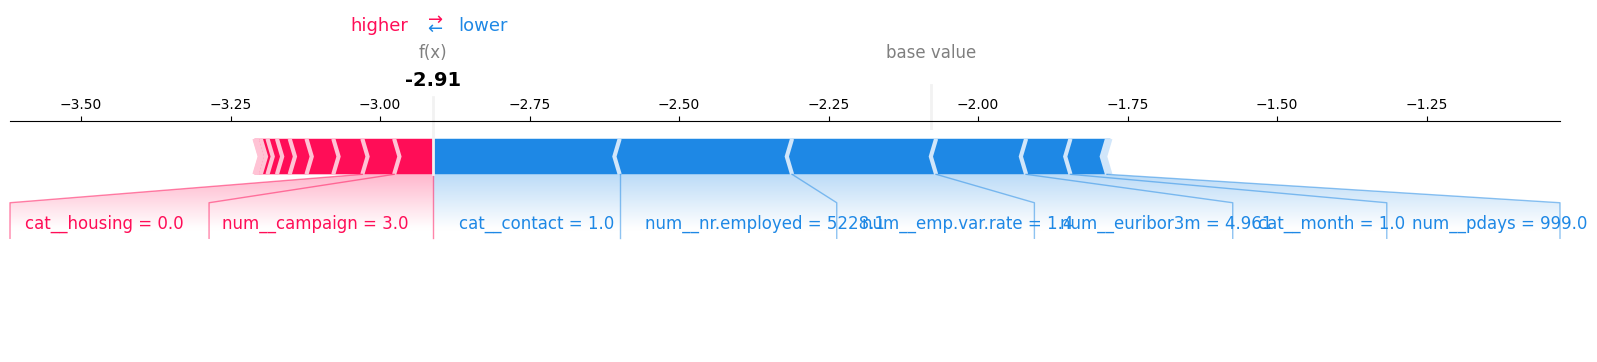

In [ ]:
i = 32949  # номер клиента
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_transformed[i],
    feature_names=feature_names,
    matplotlib=True
)

Результати показали, що найбільший вплив на передбачення має ознака `nr.employed`, яка суттєво переважає всі інші змінні. Низькі значення цього показника збільшують ймовірність позитивного відгуку клієнта, тоді як високі значення — зменшують її. Така поведінка є узгодженою з економічною логікою, оскільки рівень зайнятості відображає загальний стан ринку праці та економічний цикл.

До групи важливих ознак також належать макроекономічні індикатори `emp.var.rate` та `euribor3m`, а також поведінкові характеристики клієнта (`pdays`, `poutcome`, `contact`). Їхній вплив є стабільним та інтерпретованим, що свідчить про коректну роботу моделі.

Натомість демографічні ознаки (`job`, `marital`, `loan`, `housing`) мають мінімальний внесок у прогноз, що знижує ризик переобучення та підтверджує, що модель базується переважно на економічно та поведінково обґрунтованих факторах.

### **Таблиця результатів**

In [ ]:
results_table = pd.DataFrame([
    {
        "Модель": "Logistic Regression",
        "Гіперпараметри": "class_weight=balanced, max_iter=1000",
        "ROC-AUC (Train)": 0.7903,
        "ROC-AUC (Validation/Test)": 0.7983,
        "Коментар": "Базова інтерпретована модель. Показує стабільні результати, але має обмежену здатність до моделювання нелінійних залежностей."
    },
    {
        "Модель": "Decision Tree",
        "Гіперпараметри": "max_depth=6, class_weight=balanced",
        "ROC-AUC (Train)": 0.8013,
        "ROC-AUC (Validation/Test)": 0.7927,
        "Коментар": "Модель легко інтерпретується, але схильна до перенавчання та поступається ансамблевим методам."
    },
    {
        "Модель": "KNN",
        "Гіперпараметри": "n_neighbors=15, weights=distance",
        "ROC-AUC (Train)": 0.9979,
        "ROC-AUC (Validation/Test)": 0.7419,
        "Коментар": "Сильно перенавчається. Не рекомендована до використання без додаткового зменшення розмірності."
    },
    {
        "Модель": "XGBoost (RS, no duration)",
        "Гіперпараметри": "model__colsample_bytree: 0.9861021229056552, model__gamma: 0.1821102743060054, model__learning_rate: 0.04207993456180347, model__max_depth: 3, model__min_child_weight: 7, model__n_estimators: 364, model__subsample: 0.6062545626964776",
        "ROC-AUC (Train)": 0.8196,
        "ROC-AUC (Validation/Test)": 0.8162,
        "Коментар": "Найкраща модель за якістю. Добре узагальнює дані. Доцільно використовувати з оптимізованим порогом класифікації."
    }
])

results_table

,Модель,Гіперпараметри,ROC-AUC (Train),ROC-AUC (Validation/Test),Коментар
0,Logistic Regression,"class_weight=balanced, max_iter=1000",0.7903,0.7983,Базова інтерпретована модель. Показує стабільн...
1,Decision Tree,"max_depth=6, class_weight=balanced",0.8013,0.7927,"Модель легко інтерпретується, але схильна до п..."
2,KNN,"n_neighbors=15, weights=distance",0.9979,0.7419,Сильно перенавчається. Не рекомендована до вик...
3,"XGBoost (RS, no duration)","model__colsample_bytree: 0.9861021229056552, m...",0.8196,0.8162,Найкраща модель за якістю. Добре узагальнює да...


### **Висновок**

У межах даного проєкту було побудовано та проаналізовано кілька моделей машинного навчання для прогнозування підписки клієнтів на строковий депозит.

- **Логістична регресія** показала стабільні та інтерпретовані результати, добре узагальнювала дані та не проявляла ознак перенавчання. Вона може бути використана як базова модель для подальших порівнянь.

- **Дерево прийняття рішень** продемонструвало подібну якість до логістичної регресії, однак було більш схильним до перенавчання. Незважаючи на це, модель є простою для інтерпретації та корисною для аналізу логіки прийняття рішень.

- **Метод найближчих сусідів (KNN)** показав дуже високу якість на тренувальних даних, але суттєве погіршення на тестовому наборі, що свідчить про сильне перенавчання. Тому дана модель виявилася найменш придатною для практичного використання.

- **Модель XGBoost** продемонструвала найкращі результати серед усіх розглянутих моделей. Для неї було проведено оптимізацію гіперпараметрів за допомогою Randomized Search та бібліотеки Hyperopt, що дозволило покращити якість та стабільність прогнозування.

Окрему увагу було приділено налаштуванню порогу класифікації, що дозволило знайти баланс між повнотою та точністю. Аналіз різних значень threshold показав, що оптимальний вибір порогу суттєво впливає на практичну корисність моделі.

У ході роботи також було проведено аналіз важливості ознак та інтерпретацію моделі за допомогою бібліотеки SHAP, що дозволило краще зрозуміти фактори, які впливають на прийняття рішення.

Подальший розвиток проєкту може включати більш глибоку оптимізацію гіперпараметрів, використання ансамблевих методів, додаткову інженерію ознак, застосування методів балансування класів, а також детальніший аналіз помилок моделі.

##